In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import torch
# Disable benchmark mode and enable deterministic mode
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


# ----------------------------
# Enable Debugging
# ----------------------------
torch.autograd.set_detect_anomaly(True)

# ----------------------------
# Device Setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------
# Data Preparation
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
class MultiScalePerceptualLossNetwork(nn.Module):
    def __init__(self):
        super(MultiScalePerceptualLossNetwork, self).__init__()
        
        def conv_block(in_channels, out_channels, kernel_size, stride, padding):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        # Two parallel branches with different kernel sizes
        self.branch1 = nn.Sequential(
            conv_block(3, 64, 3, 1, 1),
            conv_block(64, 128, 3, 1, 1),
            conv_block(128, 256, 3, 1, 1)
        )
        
        self.branch2 = nn.Sequential(
            conv_block(3, 64, 5, 1, 2),
            conv_block(64, 128, 5, 1, 2),
            conv_block(128, 256, 5, 1, 2)
        )
        
        # Residual connection to directly map input to feature space
        self.residual = nn.Conv2d(3, 256, kernel_size=1)
        
    def forward(self, x):
        return self.branch1(x) + self.branch2(x) + self.residual(x)

perceptual_net = MultiScalePerceptualLossNetwork().to(device)

def perceptual_loss(fake, real):
    real_feats = perceptual_net(real)
    fake_feats = perceptual_net(fake)
    return torch.nn.functional.mse_loss(fake_feats, real_feats)

# ----------------------------
# Define the Vector Quantizer (EMA based)
# ----------------------------
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay=0.99, epsilon=1e-5):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

        self.ema_cluster_size = torch.zeros(num_embeddings, device=device)
        self.ema_weights = torch.zeros_like(self.embedding.weight, device=device)

    def forward(self, inputs):
        input_shape = inputs.shape
        flat_input = inputs.permute(0, 2, 3, 1).contiguous().view(-1, self.embedding_dim)

        distances = (
            torch.sum(flat_input ** 2, dim=1, keepdim=True)
            + torch.sum(self.embedding.weight ** 2, dim=1)
            - 2 * torch.matmul(flat_input, self.embedding.weight.t())
        )

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        quantized = torch.matmul(encodings, self.embedding.weight)

        quantized = quantized.view(input_shape[0], input_shape[2], input_shape[3], self.embedding_dim)
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        # EMA Update
        with torch.no_grad():
            self.ema_cluster_size = self.decay * self.ema_cluster_size + (1 - self.decay) * encodings.sum(0)
            self.ema_weights = self.decay * self.ema_weights + (1 - self.decay) * torch.matmul(encodings.t(), flat_input)
            n = self.ema_cluster_size.sum()
            self.ema_cluster_size = ((self.ema_cluster_size + self.epsilon) / (n + self.num_embeddings * self.epsilon) * n)
            self.embedding.weight.data = self.ema_weights / self.ema_cluster_size.unsqueeze(1)

        e_latent_loss = torch.mean((quantized.detach() - inputs) ** 2)
        q_latent_loss = torch.mean((quantized - inputs.detach()) ** 2)
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        return quantized.clone(), loss

# ----------------------------
# Define Residual Block for Encoder/Decoder
# ----------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

# ----------------------------
# Define the Encoder with Residual Connections
# ----------------------------
class Encoder(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=256, latent_dim=256):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=4, stride=2, padding=1),
            ResidualBlock(hidden_dim),
            nn.Conv2d(hidden_dim, latent_dim, kernel_size=4, stride=2, padding=1),
            ResidualBlock(latent_dim)
        )
    
    def forward(self, x):
        return self.encoder(x)

# ----------------------------
# Define the Decoder with Residual Connections
# ----------------------------
class Decoder(nn.Module):
    def __init__(self, out_channels=3, latent_dim=256, hidden_dim=256):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            ResidualBlock(latent_dim),
            nn.ConvTranspose2d(latent_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            ResidualBlock(hidden_dim),
            nn.ConvTranspose2d(hidden_dim, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.decoder(x)

# ----------------------------
# Define the VQGAN Model
# ----------------------------
class VQGAN(nn.Module):
    def __init__(self):
        super(VQGAN, self).__init__()
        self.encoder = Encoder()
        self.quantizer = VectorQuantizer(1024, 256, 0.25)
        self.decoder = Decoder()
    
    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss = self.quantizer(z)
        x_recon = self.decoder(quantized)
        return x_recon, vq_loss

# ----------------------------
# Define the Discriminator
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0)
        )
    
    def forward(self, x):
        return torch.sigmoid(self.net(x).view(x.size(0), -1))


Using device: cuda


Using device: cuda


C:\Users\abhis\AppData\Local\Temp\ipykernel_34640\2825292923.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vqgan.load_state_dict(torch.load("2novgg_vqgan.pth"))
C:\Us

Anomaly Detection Threshold: 8.0000
Accuracy: 0.7799
Precision: 0.7096
Recall: 0.8606
F1-score: 0.7778


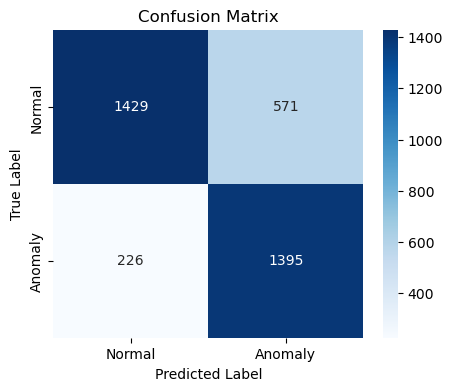

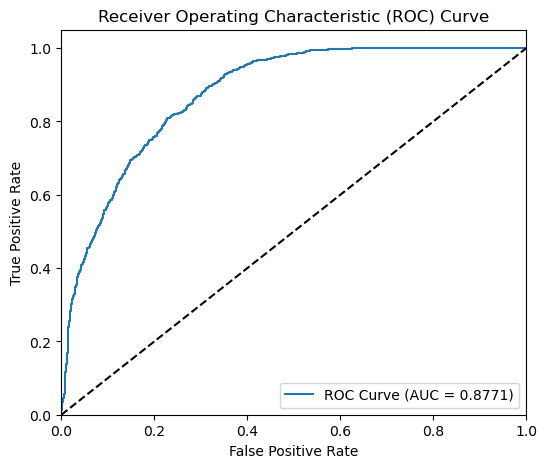

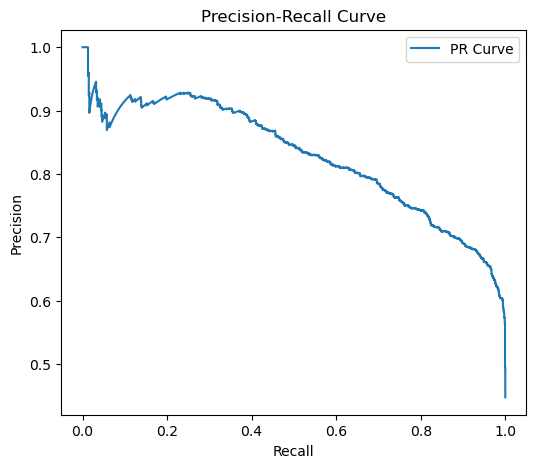

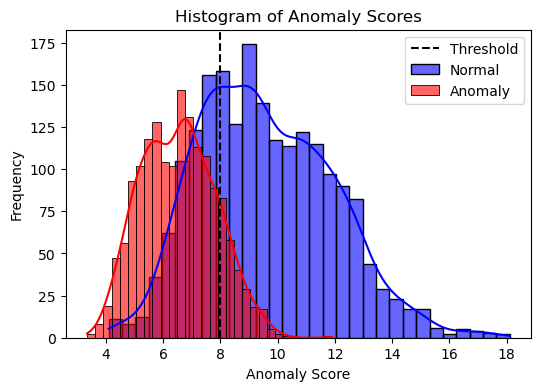

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, precision_recall_curve, confusion_matrix
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import vgg16
from torch.utils.data import DataLoader

# ----------------------------
# Device Setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------
# Load Pretrained VQGAN & Discriminator
# ----------------------------
vqgan = VQGAN().to(device)
vqgan.load_state_dict(torch.load("2novgg_vqgan.pth"))
vqgan.eval()

discriminator = Discriminator().to(device)
discriminator.load_state_dict(torch.load("2nongg_discriminator.pth"))
discriminator.eval()

# ----------------------------
# Load Pretrained Feature Extractor for Perceptual Loss (VGG16)
# ----------------------------
vgg = vgg16(pretrained=True).features[:15].to(device).eval()

# ----------------------------
# Define Test Dataset
# ----------------------------
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_dataset = datasets.ImageFolder(root="C:/Thesis ML DATA set/archive/Test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Get class mappings (0 = Normal, 1 = Anomaly)
class_map = test_dataset.class_to_idx  # Example: {'0': 0, '1': 1}
idx_to_class = {v: k for k, v in class_map.items()}  # Reverse mapping for readability

# ----------------------------
# Define Loss Computation Functions
# ----------------------------
def compute_mse_loss(original, reconstructed):
    return torch.mean((original - reconstructed) ** 2).item()

def compute_perceptual_loss(original, reconstructed, feature_extractor):
    with torch.no_grad():
        real_features = feature_extractor(original)
        fake_features = feature_extractor(reconstructed)
    return torch.nn.functional.mse_loss(real_features, fake_features).item()

def compute_discriminator_score(reconstructed):
    with torch.no_grad():
        fake_confidence = discriminator(reconstructed)
    return torch.mean(fake_confidence).item()

# ----------------------------
# Compute Predictions and Anomaly Scores
# ----------------------------
y_true = []
y_pred = []
anomaly_scores = []

for images, label in test_loader:
    images = images.to(device)
    y_true.append(label.item())  # Store actual class label

    with torch.no_grad():
        reconstructed, _ = vqgan(images)  # Get reconstructed image

    # Compute different losses
    mse_error = compute_mse_loss(images, reconstructed)
    perceptual_error = compute_perceptual_loss(images, reconstructed, vgg)
    discriminator_score = compute_discriminator_score(reconstructed)

    # Hybrid Anomaly Score (Weighted)
    total_error = (0.5 * mse_error) + (0.3 * perceptual_error) + (0.2 * (1 - discriminator_score))
    anomaly_scores.append(total_error)

# ----------------------------
# Set Adaptive Threshold Based on Healthy Data
# ----------------------------
healthy_scores = [score for score, label in zip(anomaly_scores, y_true) if label == 0]
#if len(healthy_scores) > 0:
#    mean_healthy = np.mean(healthy_scores)
 #   std_healthy = np.std(healthy_scores)
  #  threshold = mean_healthy + 2 * std_healthy
#else:
 #   threshold = np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)
threshold= 8
print(f"Anomaly Detection Threshold: {threshold:.4f}")

# Predict based on threshold
y_pred = [0 if score > threshold else 1 for score in anomaly_scores]

# ----------------------------
# Compute Metrics
# ----------------------------

# 1. Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 2. Precision, Recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# 3. Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


adjusted_scores = [-score for score in anomaly_scores]
# ----------------------------
# ROC Curve and AUC Score
# ----------------------------

fpr, tpr, _ = roc_curve(y_true, adjusted_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# ----------------------------
# Precision-Recall (PR) Curve
# ----------------------------

precision_curve, recall_curve, _ = precision_recall_curve(y_true, adjusted_scores)

plt.figure(figsize=(6, 5))
plt.plot(recall_curve, precision_curve, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# ----------------------------
# Histogram of Anomaly Scores
# ----------------------------

plt.figure(figsize=(6, 4))
sns.histplot([score for score, label in zip(anomaly_scores, y_true) if label == 0], bins=30, color="blue", label="Normal", kde=True, alpha=0.6)
sns.histplot([score for score, label in zip(anomaly_scores, y_true) if label == 1], bins=30, color="red", label="Anomaly", kde=True, alpha=0.6)
plt.axvline(threshold, color="black", linestyle="dashed", label="Threshold")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Histogram of Anomaly Scores")
plt.legend()
plt.show()
